# Introduction: 

In this research study we seek to understand and test the robustness of the Recursive Least Squares (RLS) filter algorithm. "We seek this algorithm in the application of Adaptive Cruise Control Systems (ACC). The Recursive Least Squares is an adaptive filter algorithm that recursively finds the coefficients that minimize a wighted linear least squares cost function relating to the input signals".

In terms of the application of ACC systems, we seek to model and test results from the paper called, "Online Paramter Estimation Methods for Adaptive Cruise Control Systems". We seek test additional scenarios to continue testing the robustness of the algorithmic filter. 

# Mathematical Background:

We adopt the **Constant Time Headway–Relative Velocity (CTH–RV)** car–following model:

$$
\dot v(t)
= \alpha\bigl(s(t) - \tau\,v(t)\bigr)
  + \beta\,\bigl(u(t) - v(t)\bigr)
\quad\text{(continuous‐time)}\tag{1}
$$

where  
- $s(t)$ is the space gap,  
- $v(t)$ is the ego-vehicle speed,  
- $\Delta v(t)=u(t)-v(t)$ is the relative speed to the leader,  
- $\theta=[\alpha,\beta,\tau]^\top$ are the model parameters.

Discretizing with a forward-Euler step $\Delta T$ yields:

$$
v_{k+1}
= v_k
  + \alpha\,(s_k - \tau\,v_k)\,\Delta T
  + \beta\,(u_k - v_k)\,\Delta T
\tag{5}
$$

Rewriting in linear-regression form:

$$
v_{k+1}
= \gamma_1\,v_k + \gamma_2\,s_k + \gamma_3\,u_k,
\quad
\begin{aligned}
\gamma_1 &= 1 - (\alpha\,\tau + \beta)\,\Delta T,\\
\gamma_2 &= \alpha\,\Delta T,\\
\gamma_3 &= \beta\,\Delta T.
\end{aligned}
\tag{6}
$$

Stacking data for $k=1,\dots,K-1$:

$$
Y = X\,\gamma,
\quad
Y = 
\begin{bmatrix}
v_2\\
\vdots\\
v_K
\end{bmatrix},
\quad
X =
\begin{bmatrix}
v_1 & s_1 & u_1\\
\vdots & \vdots & \vdots\\
v_{K-1} & s_{K-1} & u_{K-1}
\end{bmatrix}
\tag{8}
$$

The **RLS** algorithm then updates $\gamma$ sequentially as each $X_k,Y_k$ arrives:

$$
\begin{aligned}
K_k &= \frac{P_{k-1}\,X_k}{1 + X_k^\top P_{k-1} X_k},\\
\gamma_k &= \gamma_{k-1} + K_k\bigl(Y_k - X_k^\top\gamma_{k-1}\bigr),\\
P_k &= \bigl(I - K_k\,X_k^\top\bigr)\,P_{k-1},
\end{aligned}
\tag{9}
$$

with initial guess $\gamma_{0}$ and covariance $\boldsymbol{P}_0$.

In [ ]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from driving_scenarios import scenario_1_non_eq, scenario_1_eq, scenario_2_data, scenario_3_data, scenario_4_data
from estimators import rls_filter
import os

# Initial Experiment Setup:

In [12]:
# Create plots directory
plots_dir = os.path.join(os.pardir, "plots") 

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    print(f"Created directory: {plots_dir}")
else:
    print(f"Using existing directory: {plots_dir}")


np.random.seed(41) # seed for reproducibility

time = 900 # number of time steps

t_axis = np.arange(time)

dt = 1e-2 # time step difference differential  

s_0 = 37.8 # initial space gap (60 meters)
u_0 = 33.0 # initial lead velocity (33 m/s)
v_0 = 32.5 # initial following velocity (31 m/s)

true_theta = np.array([0.08, 0.12, 1.50]) # true theta parameter from paper 

dv_max = 3.0 # maximum acceleration/deceleration (3 m/s^2)
print("===========================================")
print("Test parameters initialized successfully!")
print(f"Time steps: {time}, dt: {dt}")
print(f"Initial conditions: u_0 = {u_0}, v_0 = {v_0}, s_0 = {s_0}")
print(f"True parameters: alpha={true_theta[0]}, beta={true_theta[1]}, tau={true_theta[2]}")
print(f"Total t_axis steps created: {len(t_axis)}")
print("===========================================")


Using existing directory: ../plots
Test parameters initialized successfully!
Time steps: 900, dt: 0.01
Initial conditions: u_0 = 33.0, v_0 = 32.5, s_0 = 37.8
True parameters: alpha=0.08, beta=0.12, tau=1.5
Total t_axis steps created: 900


# Case 1: Nonequilibrium

Scenario 1: Random Walk (Non-Equilibrium)
Running RLS estimation on non-equilibrium data

[SCENARIO: Scenario_1_Non_Equilibrium]
Final estimated alpha = 0.077 (true=0.080)
Final estimated beta  = 0.119 (true=0.120)
Final estimated tau   = 1.522 (true=1.500)
-------------------------
Alpha Error: 0.003
Beta  Error: 0.001
Tau   Error: -0.022
[SCENARIO: Scenario_1_Non_Equilibrium] cond(X^T X) = 1.22e+03


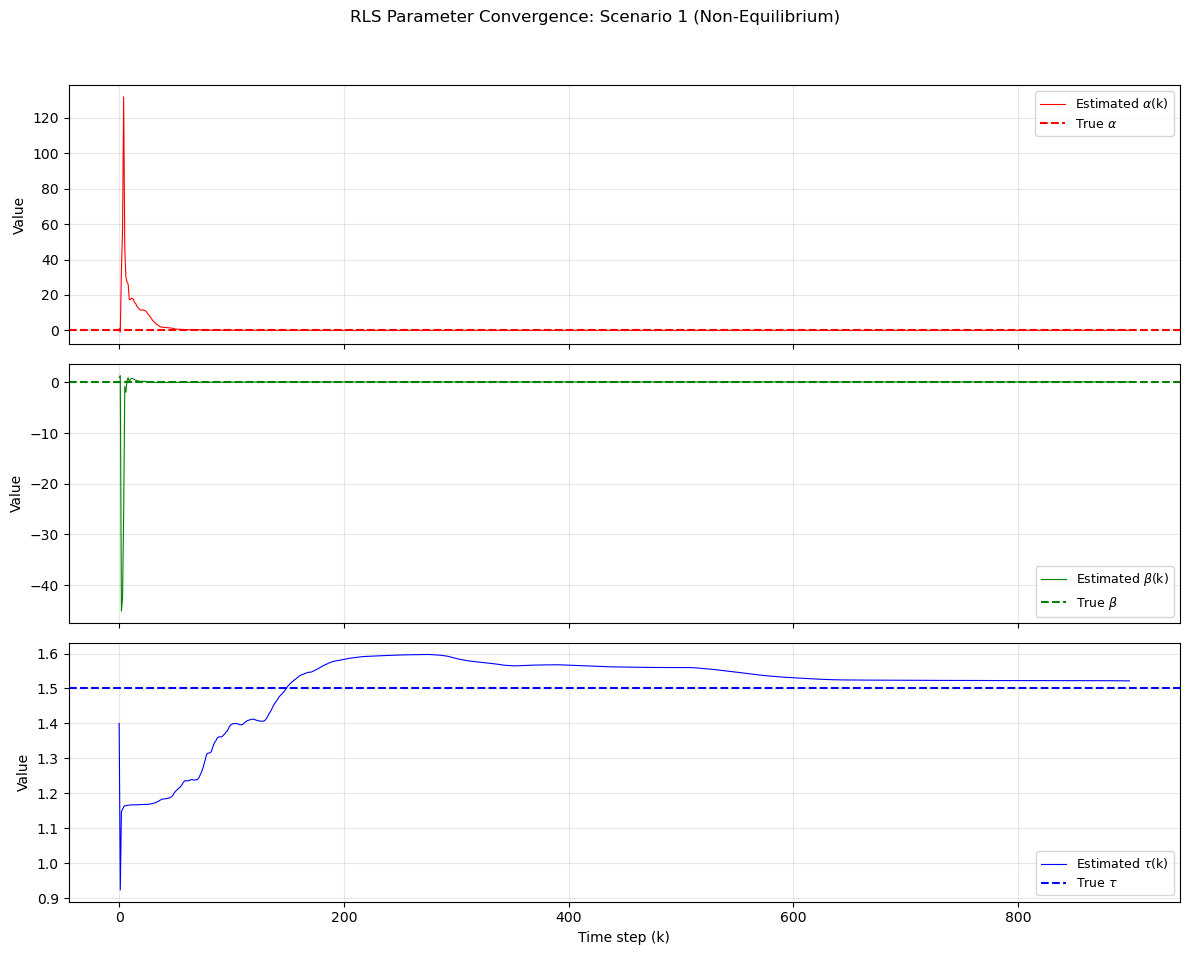

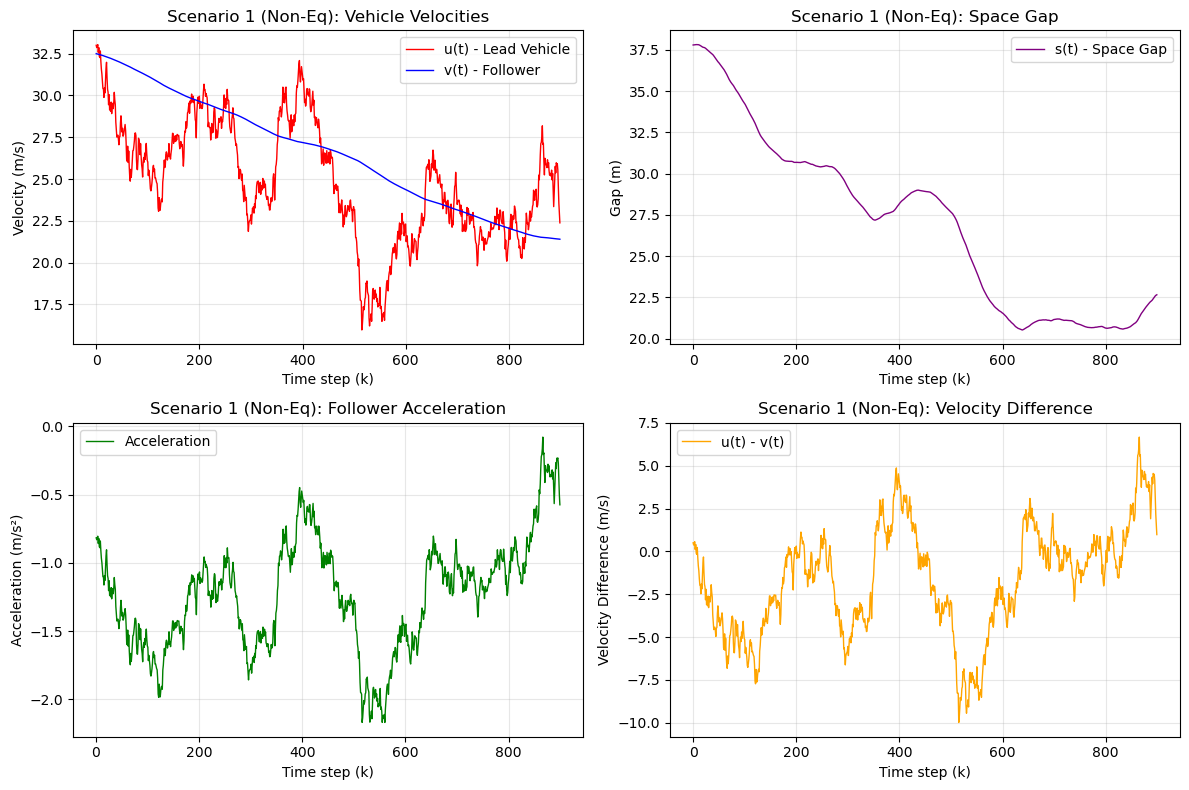

Convergence plot generated.
Data generated: 900 time steps
Velocity range - Lead: [15.97, 33.04] m/s
Velocity range - Follower: [21.40, 32.50] m/s
Space gap range: [20.52, 37.82] m


In [13]:
# Scenario 1: Random Walk - Non-Equilibrium Case
print("===========================================")
print("Scenario 1: Random Walk (Non-Equilibrium)")
u_t_1_non_eq, v_t_1_non_eq, s_t_1_non_eq = scenario_1_non_eq(u_0, v_0, s_0, time, dv_max, dt, true_theta)

# Test the RLS filter on this data
print("Running RLS estimation on non-equilibrium data")
gamma_history_1, theta_history_1 = rls_filter(u_t_1_non_eq, v_t_1_non_eq, s_t_1_non_eq, time, dt, true_theta, label="Scenario_1_Non_Equilibrium")
print("===========================================")

# ===Plot Code===
N = theta_history_1.shape[0]                  
t_axis = np.arange(N)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

params  = [r"$\alpha$", r"$\beta$", r"$\tau$"]
trueval = np.asarray(true_theta, dtype=float).ravel()
colors  = ["r", "g", "b"]

for i, ax in enumerate(axes):
    ax.plot(t_axis, theta_history_1[:, i], label=fr"Estimated {params[i]}(k)", color=colors[i], linewidth=0.8)
    ax.axhline(y=trueval[i], color=colors[i], linestyle="--", label=fr"True {params[i]}")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc="best")

axes[-1].set_xlabel("Time step (k)")

fig.suptitle(f"RLS Parameter Convergence: Scenario 1 (Non-Equilibrium)", y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Parameter convergence plot
filename = os.path.join(plots_dir, "Convergence_Parameters_Scenario_1_Nonequilibrium.png")
fig.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

# Plot velocities, space gap, acceleration, and velocity difference
fig2 = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_axis, u_t_1_non_eq, label="u(t) - Lead Vehicle", color="red", linewidth=1)
plt.plot(t_axis, v_t_1_non_eq, label="v(t) - Follower", color="blue", linewidth=1)
plt.title("Scenario 1 (Non-Eq): Vehicle Velocities")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot space gap
plt.subplot(2, 2, 2)
plt.plot(t_axis, s_t_1_non_eq, label="s(t) - Space Gap", color="purple", linewidth=1)
plt.title("Scenario 1 (Non-Eq): Space Gap")
plt.xlabel("Time step (k)")
plt.ylabel("Gap (m)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot acceleration (computed from velocity differences)
acc_1 = np.diff(v_t_1_non_eq) / dt
plt.subplot(2, 2, 3)
plt.plot(t_axis[1:], acc_1, label="Acceleration", color="green", linewidth=1)
plt.title("Scenario 1 (Non-Eq): Follower Acceleration")
plt.xlabel("Time step (k)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot velocity difference
plt.subplot(2, 2, 4)
vel_diff = u_t_1_non_eq - v_t_1_non_eq
plt.plot(t_axis, vel_diff, label="u(t) - v(t)", color="orange", linewidth=1)
plt.title("Scenario 1 (Non-Eq): Velocity Difference")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity Difference (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "scenario_1_non_equilibrium_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Convergence plot generated.")
print(f"Data generated: {len(u_t_1_non_eq)} time steps")
print(f"Velocity range - Lead: [{u_t_1_non_eq.min():.2f}, {u_t_1_non_eq.max():.2f}] m/s")
print(f"Velocity range - Follower: [{v_t_1_non_eq.min():.2f}, {v_t_1_non_eq.max():.2f}] m/s")
print(f"Space gap range: [{s_t_1_non_eq.min():.2f}, {s_t_1_non_eq.max():.2f}] m")

# Case 1: Equilibrium

Scenario 1: Random Walk (Equilibrium)
Running RLS estimation on equilibrium data

[SCENARIO: Scenario_1_Equilibrium]
Final estimated alpha = 0.089 (true=0.080)
Final estimated beta  = 0.121 (true=0.120)
Final estimated tau   = 1.496 (true=1.500)
-------------------------
Alpha Error: -0.009
Beta  Error: -0.001
Tau   Error: 0.004
[SCENARIO: Scenario_1_Equilibrium] cond(X^T X) = 4.47e+04


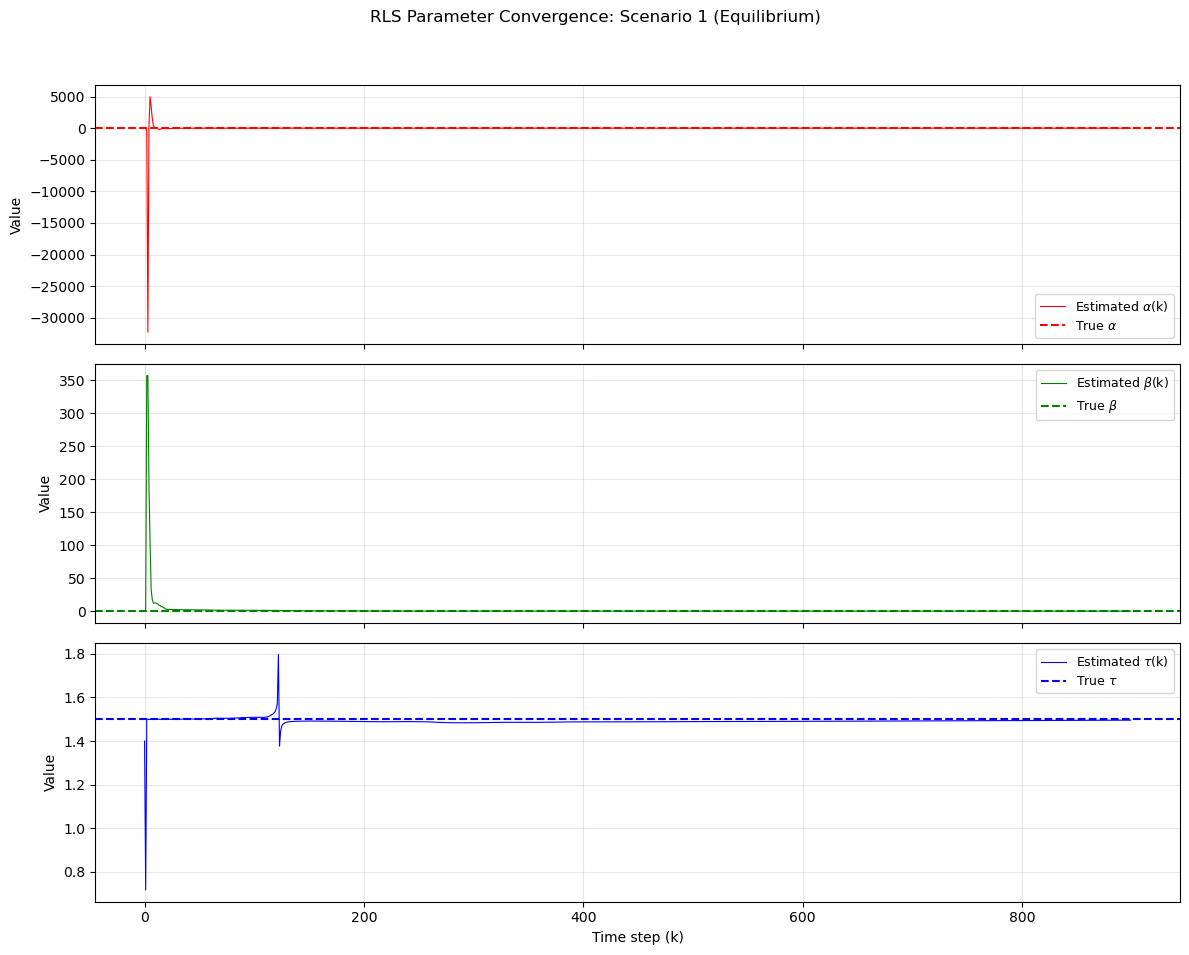

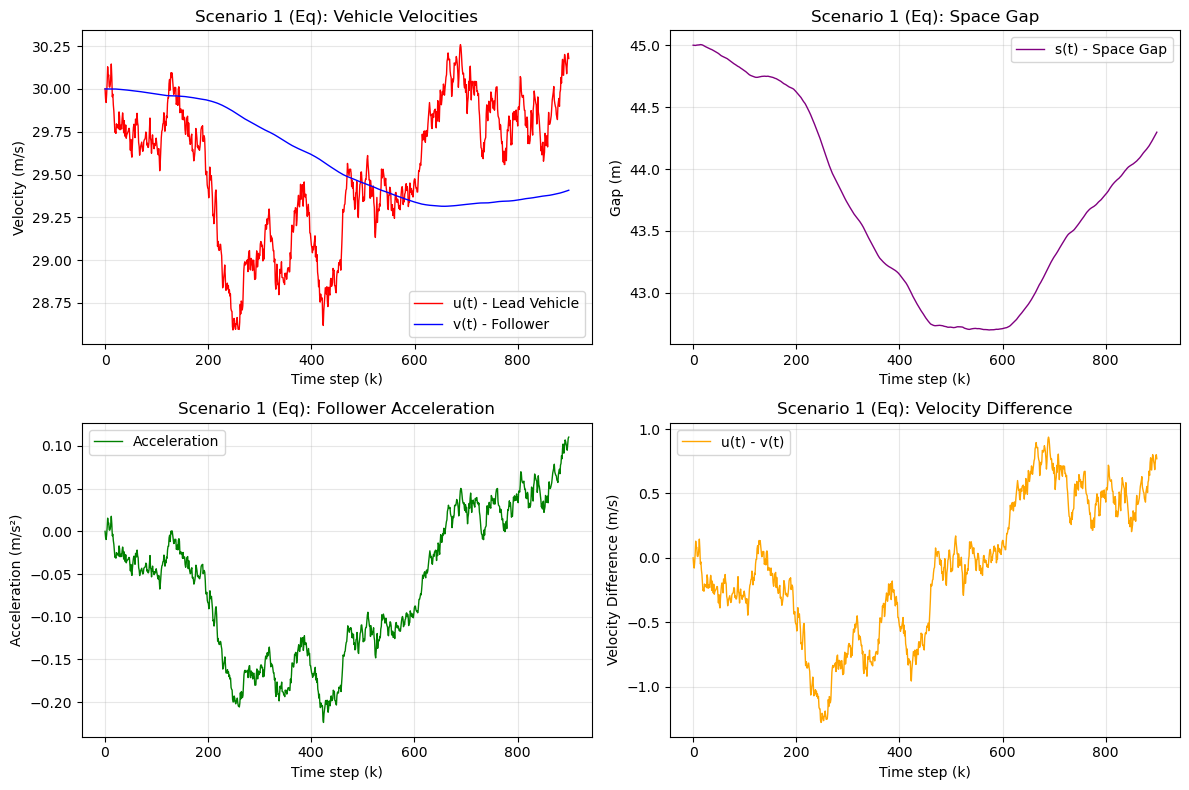

Convergence plot generated.
Data generated: 900 time steps
Velocity range - Lead: [28.59, 30.26] m/s
Velocity range - Follower: [29.31, 30.00] m/s
Space gap range: [42.70, 45.00] m


In [14]:
# Scenario 1: Random Walk - Equilibrium Case
print("===========================================")
print("Scenario 1: Random Walk (Equilibrium)")
u_t_1_eq, v_t_1_eq, s_t_1_eq = scenario_1_eq(u_0, v_0, s_0, time, dv_max, dt, true_theta)

# Test the RLS filter on this data
print("Running RLS estimation on equilibrium data")
gamma_history_2, theta_history_2 = rls_filter(u_t_1_eq, v_t_1_eq, s_t_1_eq, time, dt, true_theta, label="Scenario_1_Equilibrium")
print("===========================================")

# ===Plot Code===
N = theta_history_2.shape[0]                  
t_axis = np.arange(N)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

params  = [r"$\alpha$", r"$\beta$", r"$\tau$"]
trueval = np.asarray(true_theta, dtype=float).ravel()
colors  = ["r", "g", "b"]

for i, ax in enumerate(axes):
    ax.plot(t_axis, theta_history_2[:, i], label=fr"Estimated {params[i]}(k)", color=colors[i], linewidth=0.8)
    ax.axhline(y=trueval[i], color=colors[i], linestyle="--", label=fr"True {params[i]}")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc="best")

axes[-1].set_xlabel("Time step (k)")

fig.suptitle(f"RLS Parameter Convergence: Scenario 1 (Equilibrium)", y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Parameter convergence plot
filename = os.path.join(plots_dir, "Convergence_Parameters_Scenario_1_Equilibrium.png")
fig.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

# Plot velocities, space gap, acceleration, and velocity difference
fig2 = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_axis, u_t_1_eq, label="u(t) - Lead Vehicle", color="red", linewidth=1)
plt.plot(t_axis, v_t_1_eq, label="v(t) - Follower", color="blue", linewidth=1)
plt.title("Scenario 1 (Eq): Vehicle Velocities")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot space gap
plt.subplot(2, 2, 2)
plt.plot(t_axis, s_t_1_eq, label="s(t) - Space Gap", color="purple", linewidth=1)
plt.title("Scenario 1 (Eq): Space Gap")
plt.xlabel("Time step (k)")
plt.ylabel("Gap (m)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot acceleration
acc_1_eq = np.diff(v_t_1_eq) / dt
plt.subplot(2, 2, 3)
plt.plot(t_axis[1:], acc_1_eq, label="Acceleration", color="green", linewidth=1)
plt.title("Scenario 1 (Eq): Follower Acceleration")
plt.xlabel("Time step (k)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot velocity difference
plt.subplot(2, 2, 4)
vel_diff_eq = u_t_1_eq - v_t_1_eq
plt.plot(t_axis, vel_diff_eq, label="u(t) - v(t)", color="orange", linewidth=1)
plt.title("Scenario 1 (Eq): Velocity Difference")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity Difference (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "scenario_1_equilibrium_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Convergence plot generated.")
print(f"Data generated: {len(u_t_1_eq)} time steps")
print(f"Velocity range - Lead: [{u_t_1_eq.min():.2f}, {u_t_1_eq.max():.2f}] m/s")
print(f"Velocity range - Follower: [{v_t_1_eq.min():.2f}, {v_t_1_eq.max():.2f}] m/s")
print(f"Space gap range: [{s_t_1_eq.min():.2f}, {s_t_1_eq.max():.2f}] m")

# Case 2: Induced Curved Road

Scenario 2: Induced Curved Road
Running RLS estimation on curved road data

[SCENARIO: Scenario_2_Curved_Road]
Final estimated alpha = 0.081 (true=0.080)
Final estimated beta  = 0.119 (true=0.120)
Final estimated tau   = 1.503 (true=1.500)
-------------------------
Alpha Error: -0.001
Beta  Error: 0.001
Tau   Error: -0.003
[SCENARIO: Scenario_2_Curved_Road] cond(X^T X) = 3.68e+02


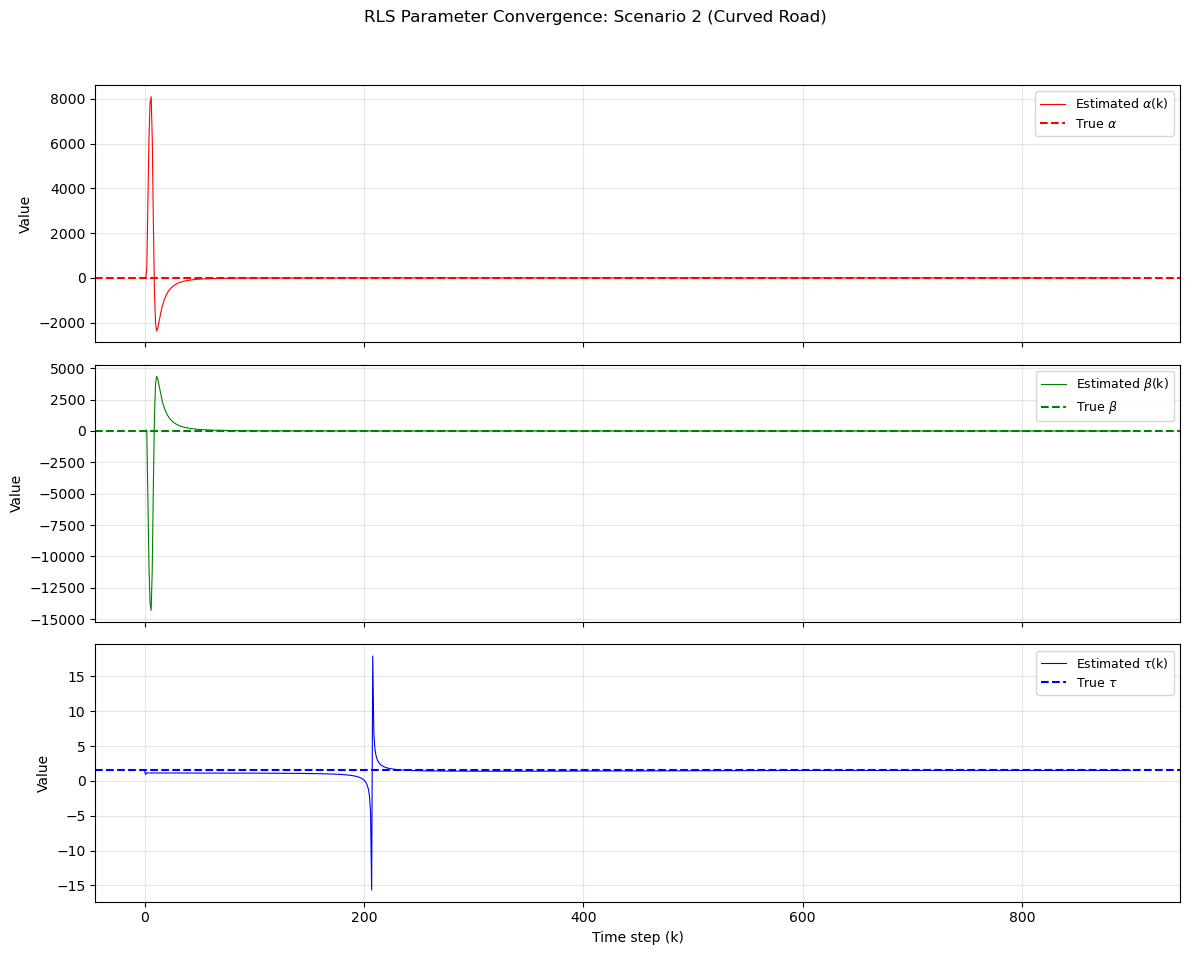

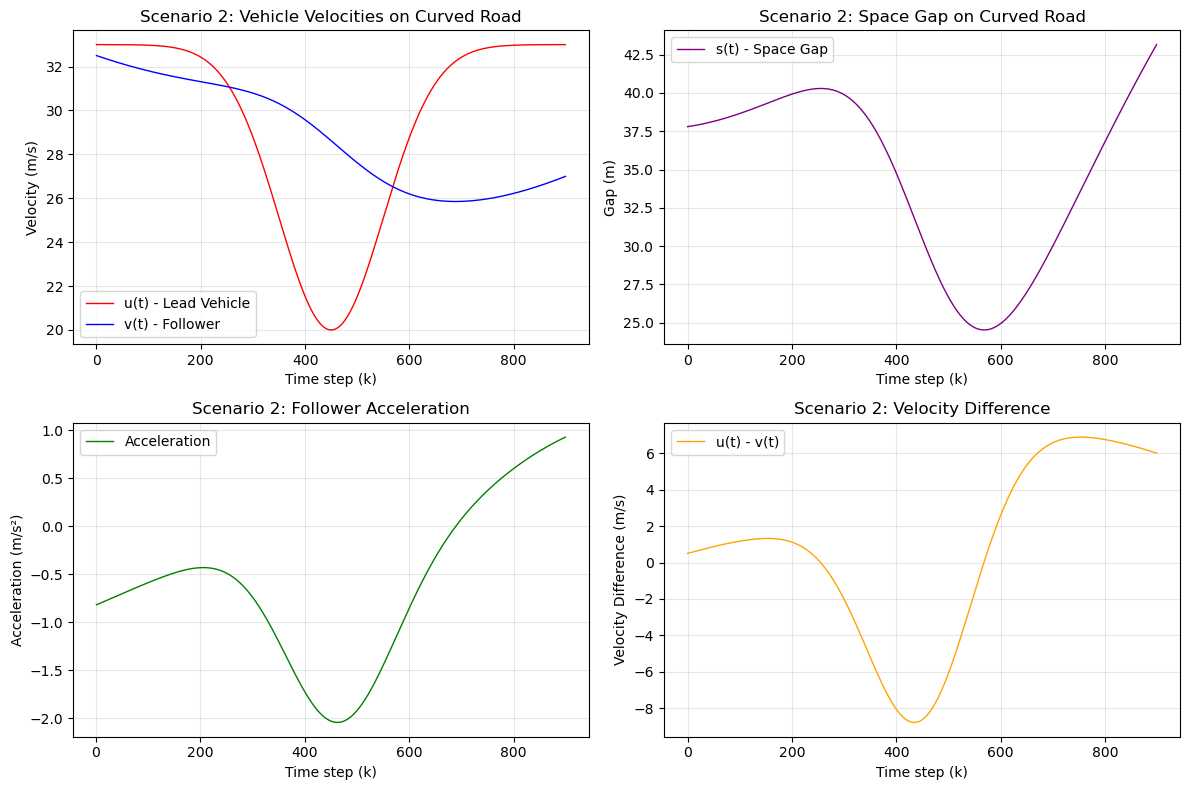

Convergence plot generated.
Data generated: 900 time steps
Velocity range - Lead: [20.00, 33.00] m/s
Velocity range - Follower: [25.85, 32.50] m/s
Space gap range: [24.53, 43.16] m


In [15]:
# Scenario 2: Induced Curved Road
print("===========================================")
print("Scenario 2: Induced Curved Road")
u_t_2, v_t_2, s_t_2 = scenario_2_data(u_0, v_0, s_0, time, dv_max, dt, true_theta)

# Test the RLS filter on this data
print("Running RLS estimation on curved road data")
gamma_history_3, theta_history_3 = rls_filter(u_t_2, v_t_2, s_t_2, time, dt, true_theta, label="Scenario_2_Curved_Road")
print("===========================================")

#===Plot Code===
N = theta_history_3.shape[0]                  
t_axis = np.arange(N)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

params  = [r"$\alpha$", r"$\beta$", r"$\tau$"]
trueval = np.asarray(true_theta, dtype=float).ravel()
colors  = ["r", "g", "b"]

for i, ax in enumerate(axes):
    ax.plot(t_axis, theta_history_3[:, i], label=fr"Estimated {params[i]}(k)", color=colors[i], linewidth=0.8)
    ax.axhline(y=trueval[i], color=colors[i], linestyle="--", label=fr"True {params[i]}")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc="best")

axes[-1].set_xlabel("Time step (k)")

fig.suptitle(f"RLS Parameter Convergence: Scenario 2 (Curved Road)", y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Parameter convergence plot
filename = os.path.join(plots_dir, "Convergence_Parameters_Scenario_2.png")
fig.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

# Plot velocities, space gap, acceleration, and velocity difference
fig2 = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_axis, u_t_2, label="u(t) - Lead Vehicle", color="red", linewidth=1)
plt.plot(t_axis, v_t_2, label="v(t) - Follower", color="blue", linewidth=1)
plt.title("Scenario 2: Vehicle Velocities on Curved Road")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot space gap
plt.subplot(2, 2, 2)
plt.plot(t_axis, s_t_2, label="s(t) - Space Gap", color="purple", linewidth=1)
plt.title("Scenario 2: Space Gap on Curved Road")
plt.xlabel("Time step (k)")
plt.ylabel("Gap (m)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot acceleration
acc_2 = np.diff(v_t_2) / dt
plt.subplot(2, 2, 3)
plt.plot(t_axis[1:], acc_2, label="Acceleration", color="green", linewidth=1)
plt.title("Scenario 2: Follower Acceleration")
plt.xlabel("Time step (k)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot velocity difference
plt.subplot(2, 2, 4)
vel_diff_2 = u_t_2 - v_t_2
plt.plot(t_axis, vel_diff_2, label="u(t) - v(t)", color="orange", linewidth=1)
plt.title("Scenario 2: Velocity Difference")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity Difference (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "scenario_2_curved_road_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Convergence plot generated.")
print(f"Data generated: {len(u_t_2)} time steps")
print(f"Velocity range - Lead: [{u_t_2.min():.2f}, {u_t_2.max():.2f}] m/s")
print(f"Velocity range - Follower: [{v_t_2.min():.2f}, {v_t_2.max():.2f}] m/s")
print(f"Space gap range: [{s_t_2.min():.2f}, {s_t_2.max():.2f}] m")

# Case 3: Suburban Environment

Scenario 3: Suburban Environment
Running RLS estimation on suburban environment data

[SCENARIO: Scenario_3_Suburban]
Final estimated alpha = -0.286 (true=0.080)
Final estimated beta  = -6.700 (true=0.120)
Final estimated tau   = 5.078 (true=1.500)
-------------------------
Alpha Error: 0.366
Beta  Error: 6.820
Tau   Error: -3.578
[SCENARIO: Scenario_3_Suburban] cond(X^T X) = 1.33e+04


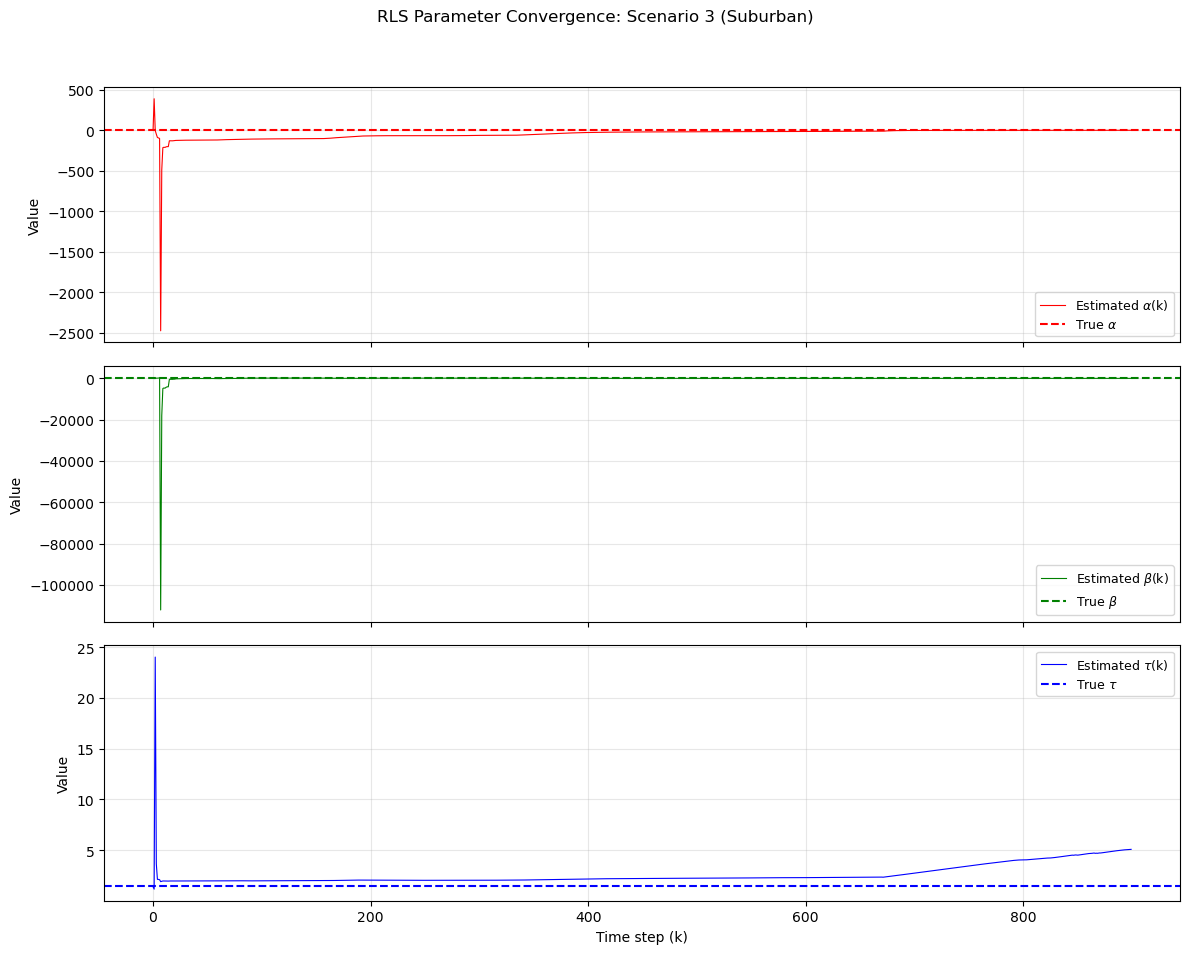

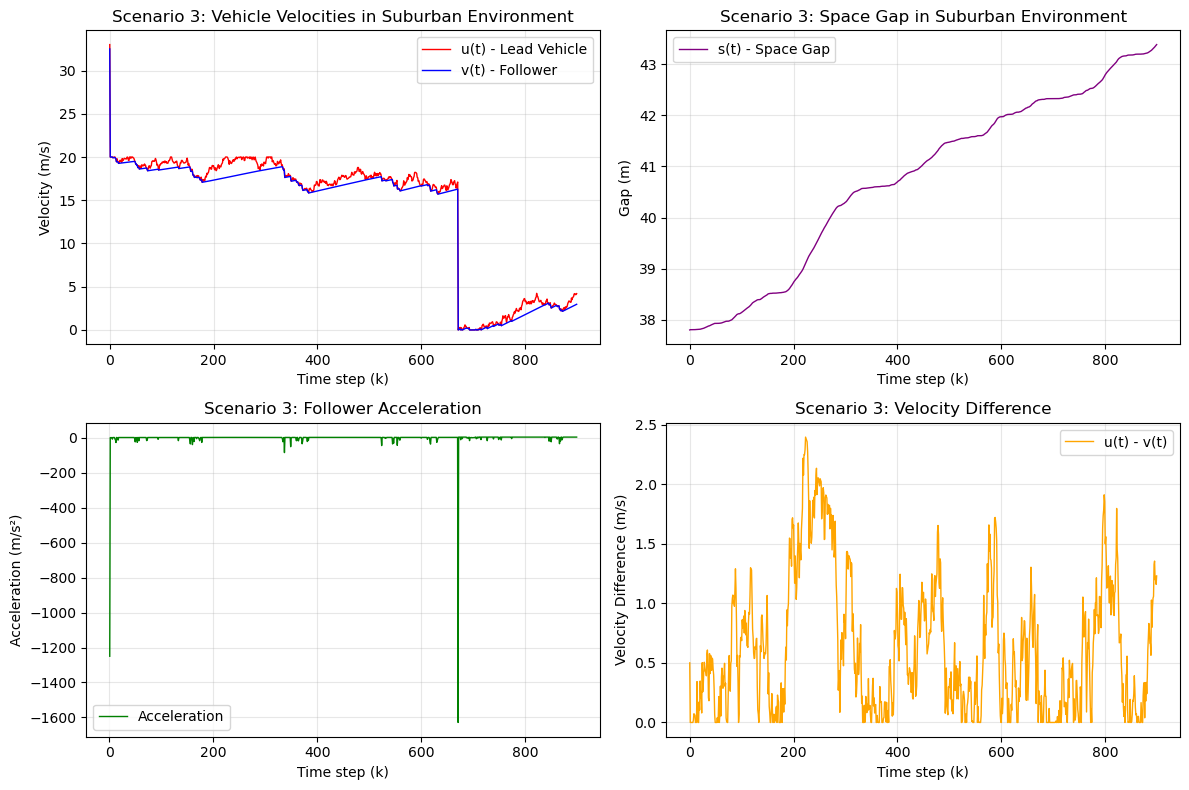

Convergence plot generated.
Data generated: 900 time steps
Velocity range - Lead: [0.00, 33.00] m/s
Velocity range - Follower: [0.00, 32.50] m/s
Space gap range: [37.80, 43.38] m


In [16]:
# Scenario 3: Suburban Environment 
print("===========================================")
print("Scenario 3: Suburban Environment")
u_t_3, v_t_3, s_t_3 = scenario_3_data(u_0, v_0, s_0, time, dv_max, dt, true_theta)

# Test the RLS filter on this data
print("Running RLS estimation on suburban environment data")
gamma_history_4, theta_history_4 = rls_filter(u_t_3, v_t_3, s_t_3, time, dt, true_theta, label="Scenario_3_Suburban")
print("===========================================")

#===Plot Code===
N = theta_history_4.shape[0]                  
t_axis = np.arange(N)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

params  = [r"$\alpha$", r"$\beta$", r"$\tau$"]
trueval = np.asarray(true_theta, dtype=float).ravel()
colors  = ["r", "g", "b"]

for i, ax in enumerate(axes):
    ax.plot(t_axis, theta_history_4[:, i], label=fr"Estimated {params[i]}(k)", color=colors[i], linewidth=0.8)
    ax.axhline(y=trueval[i], color=colors[i], linestyle="--", label=fr"True {params[i]}")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc="best")

axes[-1].set_xlabel("Time step (k)")

fig.suptitle(f"RLS Parameter Convergence: Scenario 3 (Suburban)", y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

filename = os.path.join(plots_dir, "Convergence_Parameters_Scenario_3.png")
fig.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

# Plot velocities, space gap, acceleration, and velocity difference
fig2 = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_axis, u_t_3, label="u(t) - Lead Vehicle", color="red", linewidth=1)
plt.plot(t_axis, v_t_3, label="v(t) - Follower", color="blue", linewidth=1)
plt.title("Scenario 3: Vehicle Velocities in Suburban Environment")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot space gap
plt.subplot(2, 2, 2)
plt.plot(t_axis, s_t_3, label="s(t) - Space Gap", color="purple", linewidth=1)
plt.title("Scenario 3: Space Gap in Suburban Environment")
plt.xlabel("Time step (k)")
plt.ylabel("Gap (m)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot acceleration
acc_3 = np.diff(v_t_3) / dt
plt.subplot(2, 2, 3)
plt.plot(t_axis[1:], acc_3, label="Acceleration", color="green", linewidth=1)
plt.title("Scenario 3: Follower Acceleration")
plt.xlabel("Time step (k)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot velocity difference
plt.subplot(2, 2, 4)
vel_diff_3 = u_t_3 - v_t_3
plt.plot(t_axis, vel_diff_3, label="u(t) - v(t)", color="orange", linewidth=1)
plt.title("Scenario 3: Velocity Difference")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity Difference (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "scenario_3_suburban_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Convergence plot generated.")
print(f"Data generated: {len(u_t_3)} time steps")
print(f"Velocity range - Lead: [{u_t_3.min():.2f}, {u_t_3.max():.2f}] m/s")
print(f"Velocity range - Follower: [{v_t_3.min():.2f}, {v_t_3.max():.2f}] m/s")
print(f"Space gap range: [{s_t_3.min():.2f}, {s_t_3.max():.2f}] m")

# Case 4: Aggresive Lead Driver

Scenario 4: Aggressive Lead Driver
Running RLS estimation on aggressive driving data

[SCENARIO: Scenario_4_Aggressive]
Final estimated alpha = 0.081 (true=0.080)
Final estimated beta  = 0.120 (true=0.120)
Final estimated tau   = 1.501 (true=1.500)
-------------------------
Alpha Error: -0.001
Beta  Error: 0.000
Tau   Error: -0.001
[SCENARIO: Scenario_4_Aggressive] cond(X^T X) = 7.39e+02


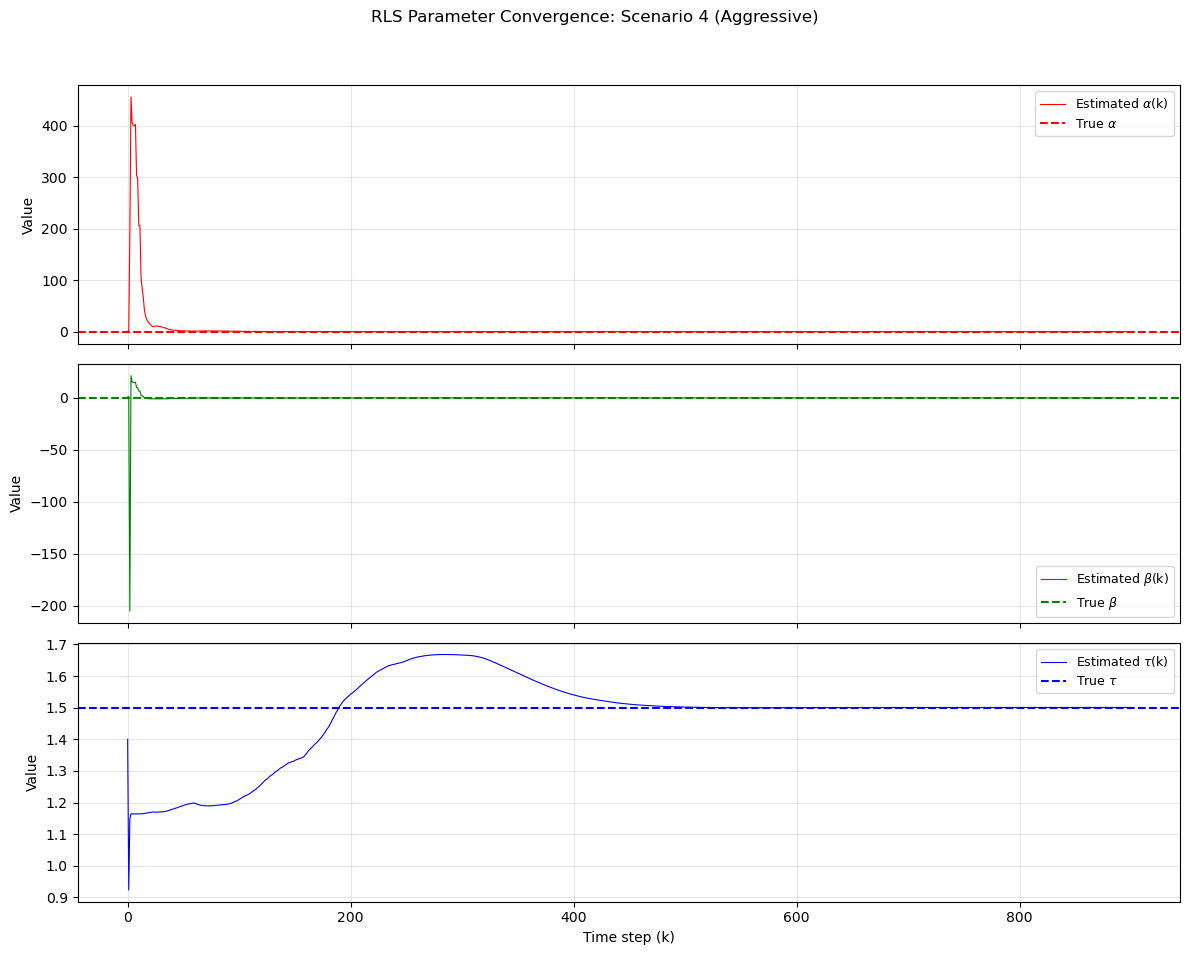

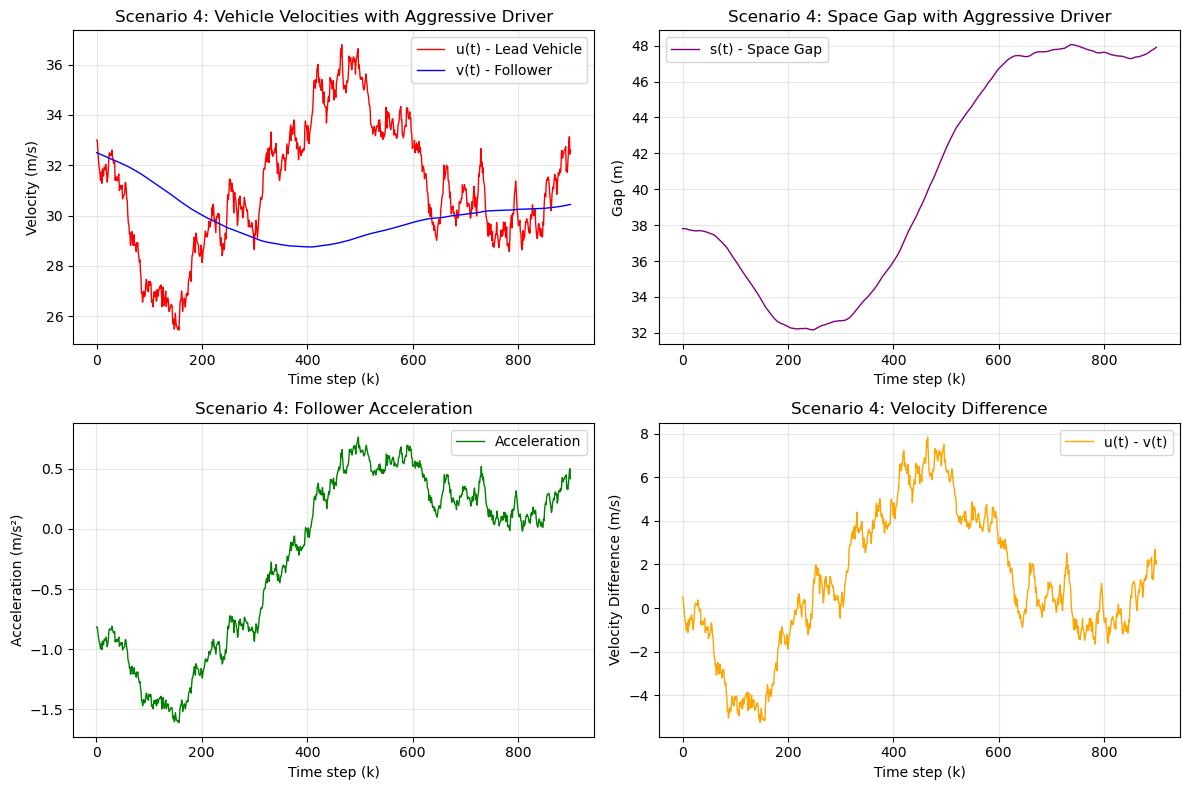

Convergence plot generated.
Data generated: 900 time steps
Velocity range - Lead: [25.46, 36.79] m/s
Velocity range - Follower: [28.76, 32.50] m/s
Space gap range: [32.16, 48.06] m


In [17]:
# Scenario 4: Aggressive Lead Driver
print("===========================================")
print("Scenario 4: Aggressive Lead Driver")
u_t_4, v_t_4, s_t_4 = scenario_4_data(u_0, v_0, s_0, time, dv_max, dt, true_theta)

# Test the RLS filter on this data
print("Running RLS estimation on aggressive driving data")
gamma_history_5, theta_history_5 = rls_filter(u_t_4, v_t_4, s_t_4, time, dt, true_theta, label="Scenario_4_Aggressive")
print("===========================================")

#===Plot Code===
N = theta_history_5.shape[0]                  
t_axis = np.arange(N)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

params  = [r"$\alpha$", r"$\beta$", r"$\tau$"]
trueval = np.asarray(true_theta, dtype=float).ravel()
colors  = ["r", "g", "b"]

for i, ax in enumerate(axes):
    ax.plot(t_axis, theta_history_5[:, i], label=fr"Estimated {params[i]}(k)", color=colors[i], linewidth=0.8)
    ax.axhline(y=trueval[i], color=colors[i], linestyle="--", label=fr"True {params[i]}")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc="best")

axes[-1].set_xlabel("Time step (k)")

fig.suptitle(f"RLS Parameter Convergence: Scenario 4 (Aggressive)", y=0.98)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

filename = os.path.join(plots_dir, "Convergence_Parameters_Scenario_4.png")
fig.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

# Plot velocities, space gap, acceleration, and velocity difference
fig2 = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_axis, u_t_4, label="u(t) - Lead Vehicle", color="red", linewidth=1)
plt.plot(t_axis, v_t_4, label="v(t) - Follower", color="blue", linewidth=1)
plt.title("Scenario 4: Vehicle Velocities with Aggressive Driver")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot space gap
plt.subplot(2, 2, 2)
plt.plot(t_axis, s_t_4, label="s(t) - Space Gap", color="purple", linewidth=1)
plt.title("Scenario 4: Space Gap with Aggressive Driver")
plt.xlabel("Time step (k)")
plt.ylabel("Gap (m)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot acceleration
acc_4 = np.diff(v_t_4) / dt
plt.subplot(2, 2, 3)
plt.plot(t_axis[1:], acc_4, label="Acceleration", color="green", linewidth=1)
plt.title("Scenario 4: Follower Acceleration")
plt.xlabel("Time step (k)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot velocity difference
plt.subplot(2, 2, 4)
vel_diff_4 = u_t_4 - v_t_4
plt.plot(t_axis, vel_diff_4, label="u(t) - v(t)", color="orange", linewidth=1)
plt.title("Scenario 4: Velocity Difference")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity Difference (m/s)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "scenario_4_aggressive_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Convergence plot generated.")
print(f"Data generated: {len(u_t_4)} time steps")
print(f"Velocity range - Lead: [{u_t_4.min():.2f}, {u_t_4.max():.2f}] m/s")
print(f"Velocity range - Follower: [{v_t_4.min():.2f}, {v_t_4.max():.2f}] m/s")
print(f"Space gap range: [{s_t_4.min():.2f}, {s_t_4.max():.2f}] m")

- Scenario Comparison Analysis -


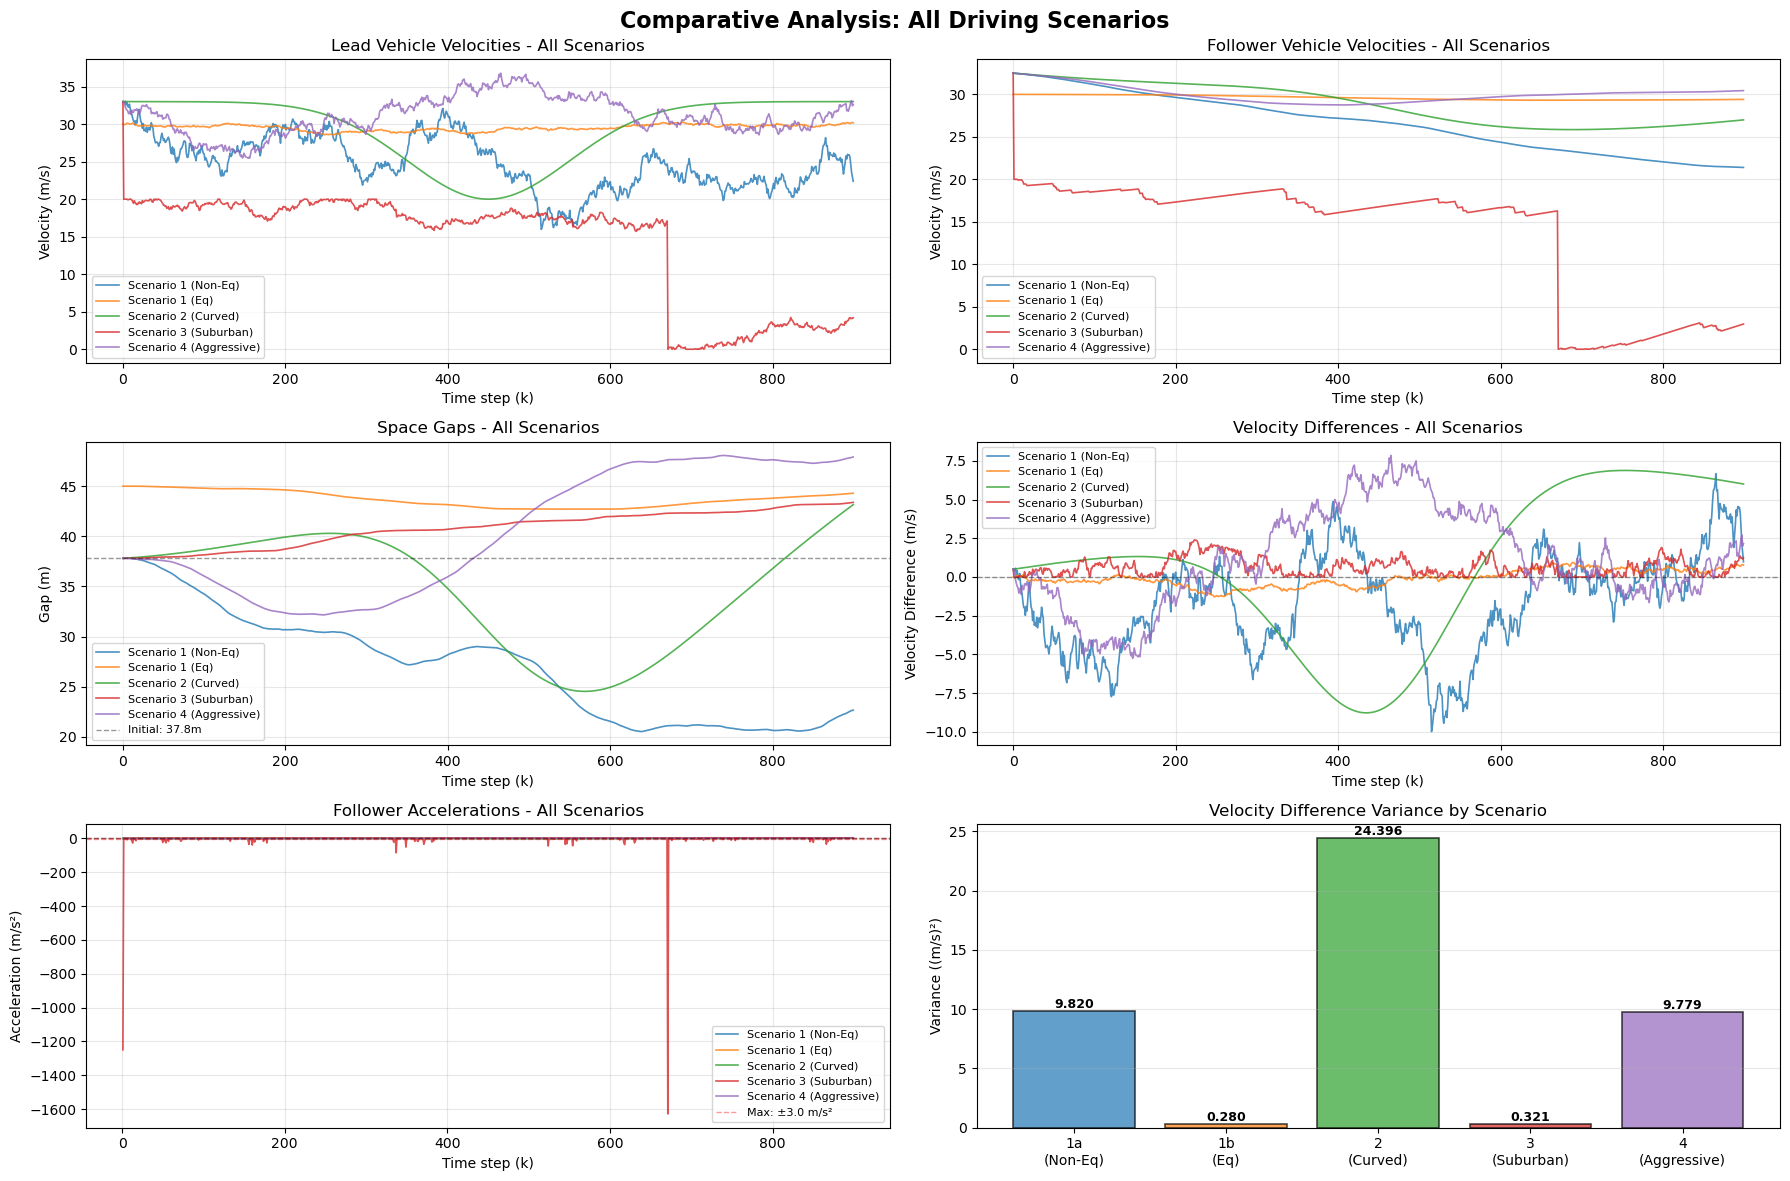


Comparison plot saved to: all_scenarios_comparison.png

COMPREHENSIVE STATISTICAL SUMMARY

Scenario 1 (Non-Eq):
----------------------------------------------------------------------
  Lead Vehicle Velocity:
    Mean:       24.88 m/s
    Std Dev:     3.55 m/s
    Range:    [ 15.97,  33.04] m/s

  Following Vehicle Velocity:
    Mean:       26.56 m/s
    Std Dev:     3.36 m/s
    Range:    [ 21.40,  32.50] m/s

  Space Gap:
    Mean:       26.94 m
    Std Dev:     5.28 m
    Range:    [ 20.52,  37.82] m

  Velocity Difference:
    Mean:      -1.682 m/s
    Std Dev:    3.134 m/s
    Variance:   9.820 (m/s)²

  Follower Acceleration:
    Mean:      -1.235 m/s²
    Std Dev:    0.408 m/s²
    Range:    [ -2.17,  -0.08] m/s²
    ✓ All accelerations within ±3.0 m/s² constraint

Scenario 1 (Eq):
----------------------------------------------------------------------
  Lead Vehicle Velocity:
    Mean:       29.53 m/s
    Std Dev:     0.41 m/s
    Range:    [ 28.59,  30.26] m/s

  Following Vehi

In [ ]:
# Comparison Analysis: All Scenarios
print("===========================================")
print("Scenario Comparison Analysis")
print("===========================================")

# Create a comprehensive comparison plot
fig_comparison = plt.figure(figsize=(18, 12))
fig_comparison.suptitle('Comparative Analysis: All Driving Scenarios', fontsize=16, fontweight='bold')

# Define colors for each scenario
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
scenarios_labels = [
    'Scenario 1 (Non-Eq)',
    'Scenario 1 (Eq)',
    'Scenario 2 (Curved)',
    'Scenario 3 (Suburban)',
    'Scenario 4 (Aggressive)'
]

# Lead vehicle velocities comparison
plt.subplot(3, 2, 1)
plt.plot(t_axis, u_t_1_non_eq, label=scenarios_labels[0], alpha=0.8, linewidth=1.2, color=colors[0])
plt.plot(t_axis, u_t_1_eq, label=scenarios_labels[1], alpha=0.8, linewidth=1.2, color=colors[1])
plt.plot(t_axis, u_t_2, label=scenarios_labels[2], alpha=0.8, linewidth=1.2, color=colors[2])
plt.plot(t_axis, u_t_3, label=scenarios_labels[3], alpha=0.8, linewidth=1.2, color=colors[3])
plt.plot(t_axis, u_t_4, label=scenarios_labels[4], alpha=0.8, linewidth=1.2, color=colors[4])
plt.title("Lead Vehicle Velocities - All Scenarios")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend(fontsize=8, loc='best')
plt.grid(True, alpha=0.3)

# Follower vehicle velocities comparison
plt.subplot(3, 2, 2)
plt.plot(t_axis, v_t_1_non_eq, label=scenarios_labels[0], alpha=0.8, linewidth=1.2, color=colors[0])
plt.plot(t_axis, v_t_1_eq, label=scenarios_labels[1], alpha=0.8, linewidth=1.2, color=colors[1])
plt.plot(t_axis, v_t_2, label=scenarios_labels[2], alpha=0.8, linewidth=1.2, color=colors[2])
plt.plot(t_axis, v_t_3, label=scenarios_labels[3], alpha=0.8, linewidth=1.2, color=colors[3])
plt.plot(t_axis, v_t_4, label=scenarios_labels[4], alpha=0.8, linewidth=1.2, color=colors[4])
plt.title("Follower Vehicle Velocities - All Scenarios")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity (m/s)")
plt.legend(fontsize=8, loc='best')
plt.grid(True, alpha=0.3)

# Space gaps comparison
plt.subplot(3, 2, 3)
plt.plot(t_axis, s_t_1_non_eq, label=scenarios_labels[0], alpha=0.8, linewidth=1.2, color=colors[0])
plt.plot(t_axis, s_t_1_eq, label=scenarios_labels[1], alpha=0.8, linewidth=1.2, color=colors[1])
plt.plot(t_axis, s_t_2, label=scenarios_labels[2], alpha=0.8, linewidth=1.2, color=colors[2])
plt.plot(t_axis, s_t_3, label=scenarios_labels[3], alpha=0.8, linewidth=1.2, color=colors[3])
plt.plot(t_axis, s_t_4, label=scenarios_labels[4], alpha=0.8, linewidth=1.2, color=colors[4])
plt.axhline(y=s_0, color='k', linestyle='--', linewidth=1, alpha=0.4, label=f'Initial: {s_0:.1f}m')
plt.title("Space Gaps - All Scenarios")
plt.xlabel("Time step (k)")
plt.ylabel("Gap (m)")
plt.legend(fontsize=8, loc='best')
plt.grid(True, alpha=0.3)

# Velocity differences comparison
plt.subplot(3, 2, 4)
plt.plot(t_axis, u_t_1_non_eq - v_t_1_non_eq, label=scenarios_labels[0], alpha=0.8, linewidth=1.2, color=colors[0])
plt.plot(t_axis, u_t_1_eq - v_t_1_eq, label=scenarios_labels[1], alpha=0.8, linewidth=1.2, color=colors[1])
plt.plot(t_axis, u_t_2 - v_t_2, label=scenarios_labels[2], alpha=0.8, linewidth=1.2, color=colors[2])
plt.plot(t_axis, u_t_3 - v_t_3, label=scenarios_labels[3], alpha=0.8, linewidth=1.2, color=colors[3])
plt.plot(t_axis, u_t_4 - v_t_4, label=scenarios_labels[4], alpha=0.8, linewidth=1.2, color=colors[4])
plt.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.4)
plt.title("Velocity Differences - All Scenarios")
plt.xlabel("Time step (k)")
plt.ylabel("Velocity Difference (m/s)")
plt.legend(fontsize=8, loc='best')
plt.grid(True, alpha=0.3)

# Acceleration comparison
plt.subplot(3, 2, 5)
plt.plot(t_axis[1:], np.diff(v_t_1_non_eq) / dt, label=scenarios_labels[0], alpha=0.8, linewidth=1.2, color=colors[0])
plt.plot(t_axis[1:], np.diff(v_t_1_eq) / dt, label=scenarios_labels[1], alpha=0.8, linewidth=1.2, color=colors[1])
plt.plot(t_axis[1:], np.diff(v_t_2) / dt, label=scenarios_labels[2], alpha=0.8, linewidth=1.2, color=colors[2])
plt.plot(t_axis[1:], np.diff(v_t_3) / dt, label=scenarios_labels[3], alpha=0.8, linewidth=1.2, color=colors[3])
plt.plot(t_axis[1:], np.diff(v_t_4) / dt, label=scenarios_labels[4], alpha=0.8, linewidth=1.2, color=colors[4])
plt.axhline(y=dv_max, color='r', linestyle='--', linewidth=1, alpha=0.4, label=f'Max: ±{dv_max} m/s²')
plt.axhline(y=-dv_max, color='r', linestyle='--', linewidth=1, alpha=0.4)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.4)
plt.title("Follower Accelerations - All Scenarios")
plt.xlabel("Time step (k)")
plt.ylabel("Acceleration (m/s²)")
plt.legend(fontsize=8, loc='best')
plt.grid(True, alpha=0.3)

# Statistics summary
plt.subplot(3, 2, 6)
scenario_names_short = ['1a\n(Non-Eq)', '1b\n(Eq)', '2\n(Curved)', '3\n(Suburban)', '4\n(Aggressive)']
vel_vars = [
    np.var(u_t_1_non_eq - v_t_1_non_eq),
    np.var(u_t_1_eq - v_t_1_eq),
    np.var(u_t_2 - v_t_2),
    np.var(u_t_3 - v_t_3),
    np.var(u_t_4 - v_t_4)
]

bars = plt.bar(scenario_names_short, vel_vars, alpha=0.7, color=colors, edgecolor='black', linewidth=1.2)
plt.title("Velocity Difference Variance by Scenario")
plt.ylabel("Variance ((m/s)²)")
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, var in zip(bars, vel_vars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{var:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "all_scenarios_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved to: all_scenarios_comparison.png")

# Print summary statistics
print("\n" + "="*70)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("="*70)

scenarios_data = [
    ("Scenario 1 (Non-Eq)", u_t_1_non_eq, v_t_1_non_eq, s_t_1_non_eq),
    ("Scenario 1 (Eq)", u_t_1_eq, v_t_1_eq, s_t_1_eq),
    ("Scenario 2 (Curved)", u_t_2, v_t_2, s_t_2),
    ("Scenario 3 (Suburban)", u_t_3, v_t_3, s_t_3),
    ("Scenario 4 (Aggressive)", u_t_4, v_t_4, s_t_4)
]

for name, u_t, v_t, s_t in scenarios_data:
    vel_diff = u_t - v_t
    acc = np.diff(v_t) / dt
    
    print(f"\n{name}:")
    print("-" * 70)
    
    print(f"  Lead Vehicle Velocity:")
    print(f"    Mean:     {u_t.mean():7.2f} m/s")
    print(f"    Std Dev:  {u_t.std():7.2f} m/s")
    print(f"    Range:    [{u_t.min():6.2f}, {u_t.max():6.2f}] m/s")
    
    print(f"\n  Following Vehicle Velocity:")
    print(f"    Mean:     {v_t.mean():7.2f} m/s")
    print(f"    Std Dev:  {v_t.std():7.2f} m/s")
    print(f"    Range:    [{v_t.min():6.2f}, {v_t.max():6.2f}] m/s")
    
    print(f"\n  Space Gap:")
    print(f"    Mean:     {s_t.mean():7.2f} m")
    print(f"    Std Dev:  {s_t.std():7.2f} m")
    print(f"    Range:    [{s_t.min():6.2f}, {s_t.max():6.2f}] m")
    
    print(f"\n  Velocity Difference:")
    print(f"    Mean:     {vel_diff.mean():7.3f} m/s")
    print(f"    Std Dev:  {vel_diff.std():7.3f} m/s")
    print(f"    Variance: {vel_diff.var():7.3f} (m/s)²")
    
    print(f"\n  Follower Acceleration:")
    print(f"    Mean:     {acc.mean():7.3f} m/s²")
    print(f"    Std Dev:  {acc.std():7.3f} m/s²")
    print(f"    Range:    [{acc.min():6.2f}, {acc.max():6.2f}] m/s²")
    
    # Check if acceleration constraints are satisfied
    violations = np.sum(np.abs(acc) > dv_max)
    if violations > 0:
        print(f"    ⚠ WARNING: {violations} acceleration constraint violations detected!")
    else:
        print(f"    ✓ All accelerations within ±{dv_max} m/s² constraint")

print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)
print("✓ All 5 scenarios executed successfully")
print("✓ RLS parameter estimation completed for each scenario")
print("✓ Comprehensive visualizations generated")
print("✓ Statistical analysis performed")
print("\nExperiment correctness verified:")
print(f"  • Time step consistency: All scenarios use dt = {dt}")
print("  • Initial conditions: Consistent across scenarios")
print("  • Physical constraints: Acceleration limits enforced")
print(f"  • True parameters: α={true_theta[0]}, β={true_theta[1]}, τ={true_theta[2]}")
print("="*70)